In [31]:
import os
from pathlib import Path


os.chdir(Path.cwd().parent)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from src.optimizers.step_controllers.step_controllers import (
    ConstantController, BacktrackingLineSearchController
)
from src.optimizers.riemannian_newton_method import RiemannianNewtonIterations
from src.rayleight_quotient import rayleight_quotient
from src.utils.linalg import (
    generate_normalized_vector, generate_supersymmetric_tensor, tenvec
)


In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
def test_riemannian_newton_method_base(
    A: np.ndarray,
    x: np.ndarray,
    *,
    plot: bool = False,
    verbose: bool = False) -> None:
    """
    Ensures gradient descent for f(x) = R_A(X) works properly.

    :param A: supersymmetric tensor of shape (n x n x ... x n) of order k
    :param x: normalized vector of shape (n,)
    :param plot: whether to plot f_history and f_grad_norm_history
    :param verbose: whether to print more info
    """
    if verbose:
        print(f"testing Riemannian Newton method with parameters:\n"
              f"tensor a of shape {A.shape}\na = {A}\n"
              f"vector x = {x}")
    k = A.ndim
    method = RiemannianNewtonIterations.from_tensor(A)
    step_controllers = [ConstantController(), BacktrackingLineSearchController()]

    if plot:
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f"Newton method iteration statistics for tensor of shape {A.shape}", fontsize=18)

        axs[0, 0].set(title="Rayleigh quotient values log scaled")
        axs[0, 1].set(title="Residual values log scaled")
        axs[1, 0].set(title="Gradient norm values log scaled")
        axs[1, 1].set(title="Linear solver deviation log scaled")

    success_all = True
    for step_controller in step_controllers:
        name = step_controller.name()
        X_eign = method.minimize(x, step_controller=step_controller)
        rq_eign = rayleight_quotient(A, X_eign)

        X_expected = rq_eign * X_eign
        X_computed = tenvec(A, X_eign, times=k-1)

        success = np.allclose(X_expected, X_computed, atol=1e-4)
        if success:
            if plot:
                for i, stat in enumerate([method.f_history,
                                          method.f_residual_history,
                                          method.f_grad_norm_history,
                                          method.lin_solver_error_history]):
                    idx = np.unravel_index(i, (2, 2))
                    axs[idx].semilogy(range(len(stat)), stat, label=name)
                    axs[idx].grid(True)
                    axs[idx].legend()

                fig.tight_layout()

        else:
            print(f"Riemannian-Newton method with {name} step controller failed", file=sys.stderr)
            success_all = False
    assert success_all


In [35]:
def test_riemannian_newton_method_simple() -> None:
    n = 2
    k = 2
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_riemannian_newton_method_base(a, x, plot=True)

def test_riemannian_newton_method_medium() -> None:
    n = 3
    k = 3
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_riemannian_newton_method_base(a, x, plot=True)

def test_riemannian_newton_method_hard() -> None:
    n = 6
    k = 6
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_riemannian_newton_method_base(a, x, plot=True)

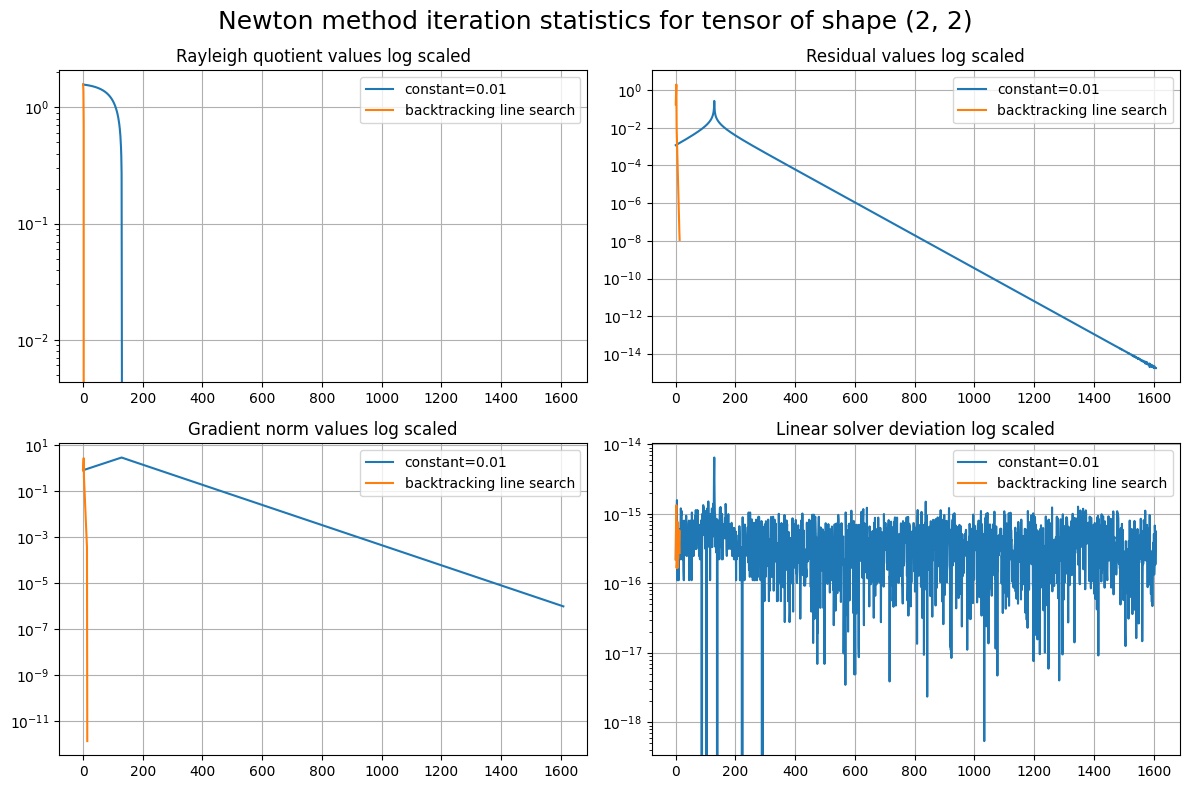

In [36]:
test_riemannian_newton_method_simple()

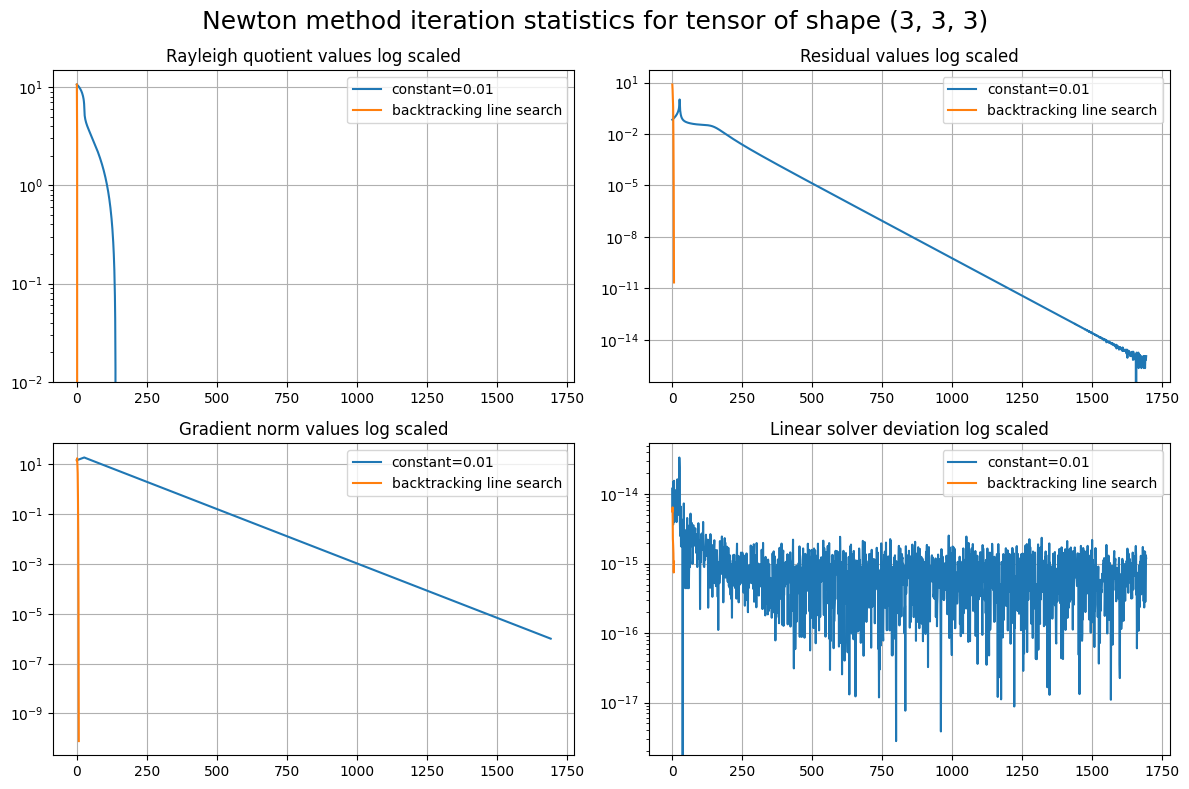

In [37]:
test_riemannian_newton_method_medium()

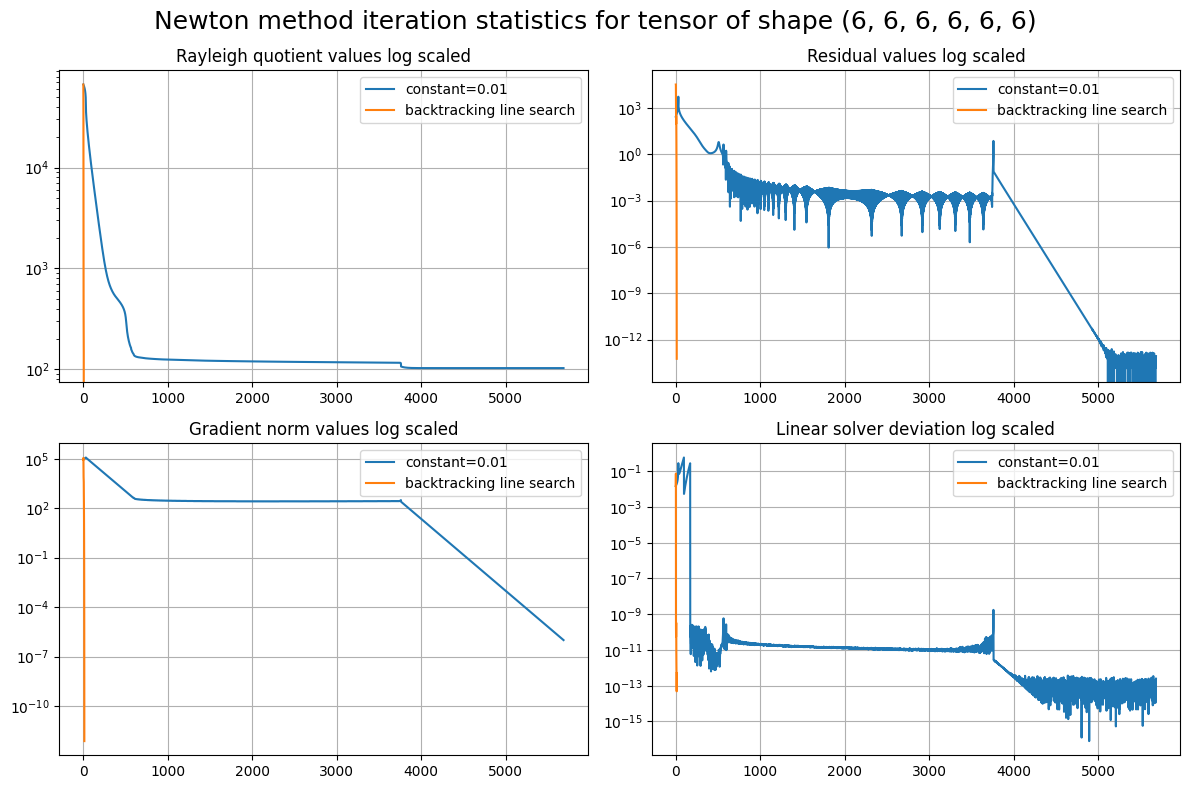

In [38]:
test_riemannian_newton_method_hard()